In [14]:
library(tidyverse)
library(nycflights13)
library(broom)
library(modelr)  
library(lubridate)

options(repr.plot.width=5, repr.plot.height=3)

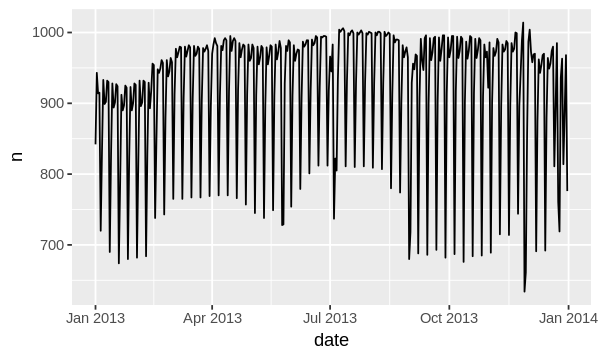

In [15]:
#### Beispiel Flugdaten
# Zielvariable: Number of flights

### Daten betrachten
daily <- flights %>%
  mutate(date = make_date(year, month, day)) %>%
  group_by(date) %>%
  summarize(n = n())

ggplot(daily, aes(date, n)) +
  geom_line()
# PROBLEM: Langzeittrend schwer erkennbar
#  => starker day-of-week Effekt dominiert subtilere Muster

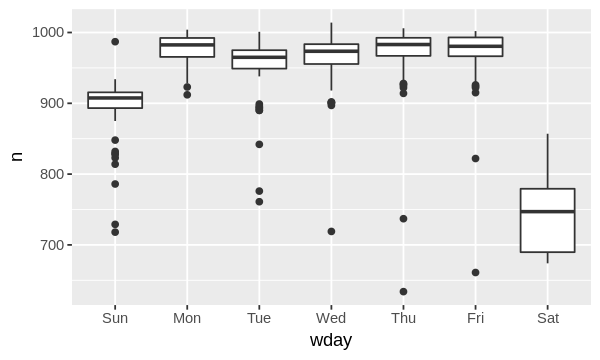

In [16]:
### UNTERSUCHEN DES DAY-OF-WEEK EFFEKTS
daily <- daily %>%
  mutate(wday = wday(date, label = TRUE))
ggplot(daily, aes(wday, n)) +
  geom_boxplot()
# => weniger Flüge am Wochenende

In [20]:
### ENTFERNEN DES TAG-ZU-TAG MUSTER
# Durch Modell
# 1. Modell erzeugen & Predictions mit Originaldaten überlagern
# 2. Berechnen und visualisieren der Residuals

## ===> ERLAUBT SUBTILERE MUSTER ZU ERKENNEN

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


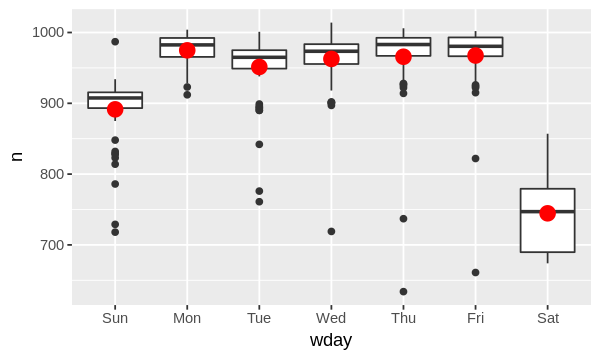

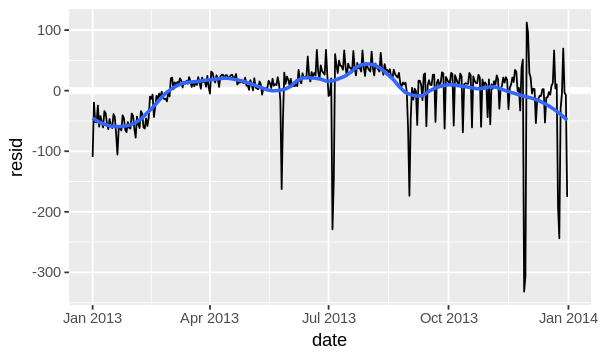

In [21]:
## 1. Modell erzeugen & Predictions überlagern
mod <- lm(n ~ wday, data = daily)
grid <- daily %>%
  data_grid(wday) %>%
  add_predictions(mod, "n")
ggplot(daily, aes(wday, n)) +
  geom_boxplot() +
  geom_point(data = grid, color = "red", size = 4)#
#
## 2. Berchnen und visualisieren der Residuals
daily <- daily %>%
  add_residuals(mod)
daily %>%
  ggplot(aes(date, resid)) +
  geom_ref_line(h = 0) +
  geom_line() + 
  geom_smooth(se = FALSE, span = 0.20)
# Y-Achse: y-axis: sieht Abweichung von erwarteter Anzahl von Flügen,
#                  bei gegebenen Tag der Woche

# => Effekt von Day-of-Week entfernt - erlaubt nun subtilere Muster zu sehen

date,n,wday,resid,term
<date>,<int>,<ord>,<dbl>,<fct>
2013-11-28,634,Thu,-331.7500,fall
2013-11-29,661,Fri,-306.4615,fall
2013-12-25,719,Wed,-243.6923,fall
2013-07-04,737,Thu,-228.7500,summer
2013-12-24,761,Tue,-190.3585,fall
2013-12-31,776,Tue,-175.3585,fall
2013-09-01,718,Sun,-173.4808,fall
2013-05-26,729,Sun,-162.4808,spring
2013-07-05,822,Fri,-145.4615,summer


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


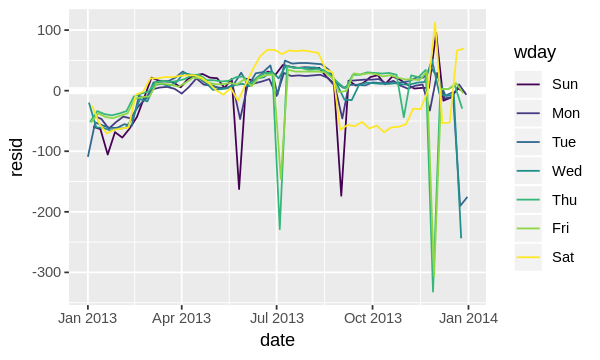

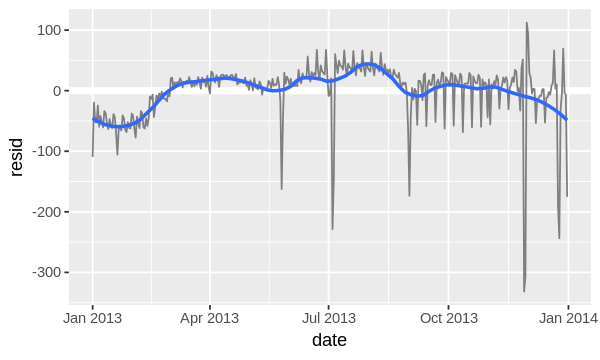

In [35]:
## Modell scheint ab Juni nicht richtig zu sein
# => Ursache sehen in Plot mit einer Linie pro Tag
ggplot(daily, aes(date, resid, color = wday)) +
  geom_ref_line(h = 0) +
  geom_line()

# Zudem einige Tage mit weit weniger Flügen als erwartet
daily %>%
  filter(resid < -100) %>%
  arrange(resid)
# => Neujahr, 4. Juli, Thanksgiving und Christmas

## LANGZEIT-TREND über das Jahr gesehen
daily %>%
  ggplot(aes(date, resid)) + 
    geom_ref_line(h = 0) + 
    geom_line(color = "grey50") + 
    geom_smooth(se = FALSE, span = 0.20)
# => anscheinend jahrezeiten-abhängig

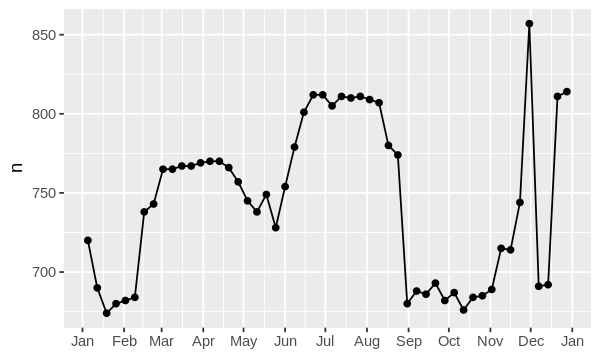

In [25]:
### JAHRESZEIT-EFFEKT & SAMSTAGE

## Samstags Effekt
daily %>%
  filter(wday == "Sat") %>%
  ggplot(aes(date, n)) +
    geom_point() +
    geom_line() +
    scale_x_date(
      NULL,
      date_breaks = "1 month", date_labels = "%b")
# => offentsichlich Sommerferien

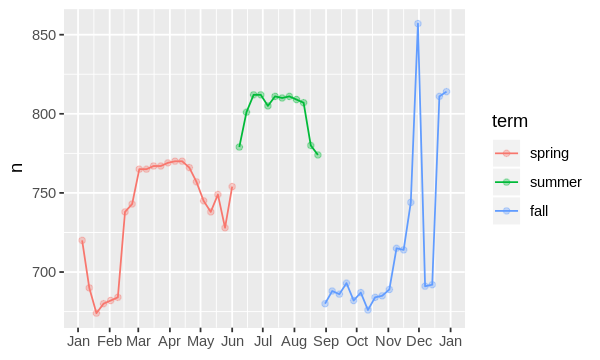

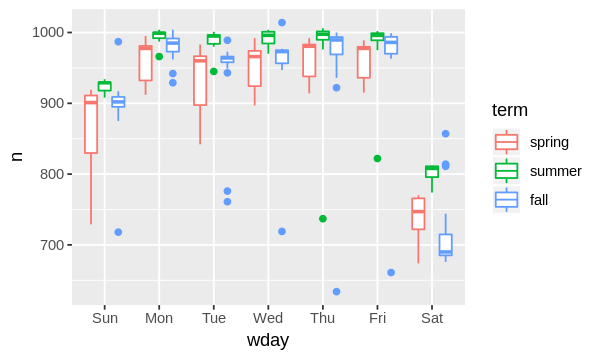

In [27]:
## Wie beeinflusst Jahreszeit das Day-of-week Muster

## Jahrezeit-Variable einführen
term <- function(date) {
  cut(date,
      breaks = ymd(20130101, 20130605, 20130825, 20140101),
      labels = c("spring", "summer", "fall")
  )
}
daily <- daily %>%
  mutate(term = term(date))
daily %>%
  filter(wday == "Sat") %>%
  ggplot(aes(date, n, color = term)) +
  geom_point(alpha = 1/3) +
  geom_line() +
  scale_x_date(
    NULL,
    date_breaks = "1 month", date_labels = "%b")


daily %>%
  ggplot(aes(wday, n, color = term)) +
  geom_boxplot()
# => starke Variation zwischen den Jahrezeiten
# ==> beide fitten - verbessert Modell

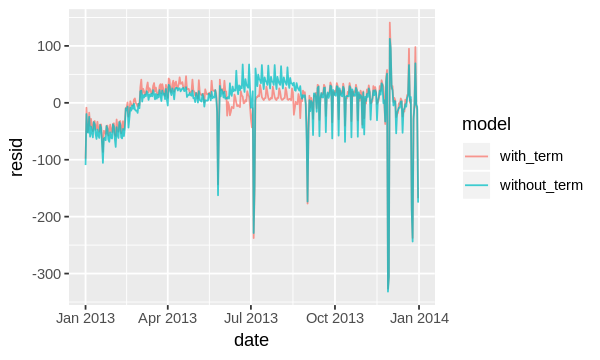

In [28]:
mod1 <- lm(n ~ wday, data = daily)
mod2 <- lm(n ~ wday * term, data = daily)

daily %>%
  gather_residuals(without_term = mod1, with_term = mod2) %>%
  ggplot(aes(date, resid, color = model)) +
  geom_line(alpha = 0.75)
# => immernoch nicht optimal 
# ==> genauer betrachten durch überlagern der Predictions mit orginal Daten

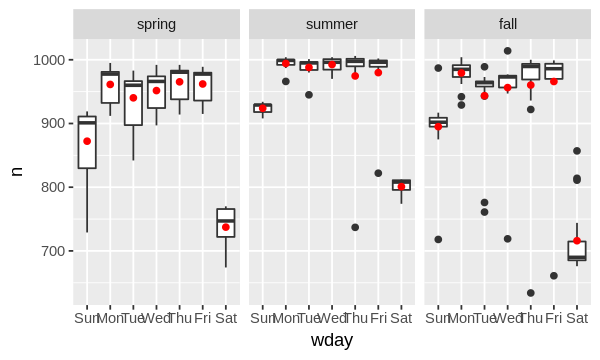

In [30]:
## Überlagern der Predictions mit orginal Daten
grid <- daily %>%
  data_grid(wday, term) %>%
  add_predictions(mod2, "n")
ggplot(daily, aes(wday, n)) +
  geom_boxplot() +
  geom_point(data = grid, color = "red") +
  facet_wrap(~ term)
# => Modell bestimmt mean-value - aber starke Ausreisser, 
#    welche das Ergebnis verzerren
# ==> besser: Robuste Regression

In [ ]:
### Robuste Regression - robust gegen Ausreisser
mod3 <- MASS::rlm(n ~ wday * term, data = daily)

daily %>%
  add_residuals(mod3, "resid") %>%
  ggplot(aes(date, resid)) +
  geom_hline(yintercept = 0, size = 2, color = "white") +
  geom_line() +
  geom_smooth(se = FALSE, span = 0.20)
# => einfacher den Langzeit-Trend und die positiven/negativen Outlier zu erkennen

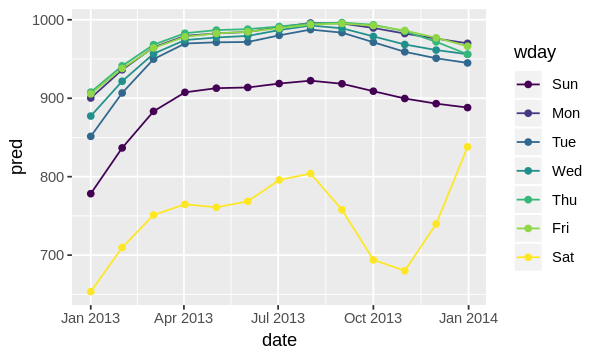

In [31]:
## NATURAL SPLINES: 
# => Jahreszeit - alternativer Ansatz: Natural Splines

# vorher: Domain knowledge benutzt
# jetzt: flexibleres Modell benutzen

## Linearer Trend nicht adäquat Daten nicht gut 
#   => Natural Spline verwenden
library(splines)

mod <- MASS::rlm(n ~ wday * ns(date, 5), data = daily)

daily %>%
  data_grid(wday, date = seq_range(date, n = 13)) %>%
  add_predictions(mod) %>%
  ggplot(aes(date, pred, color = wday)) +
  geom_line() +
  geom_point()
# => sieht gut den Trend an Samstagen

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


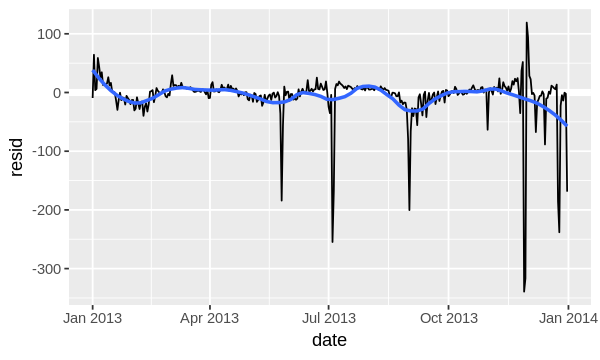

In [32]:
daily %>%
  add_residuals(mod, "resid") %>%
  ggplot(aes(date, resid)) +
  geom_hline(yintercept = 0, size = 2, color = "white") +
  geom_line() +
  geom_smooth(se = FALSE, span = 0.20)

## Globale Funktion zur Variablen Transformation
# damit einheitlich, wenn an mehreren Stellen benutzt
compute_vars <- function(data) {
  data %>%
    mutate(
      term = term(date),
      wday = wday(date, label = TRUE)
    ) 
}